In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#Import necessary libraries:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


In [19]:
# Load and preprocess the data:
IMG_SIZE = 224  # ResNet input size

train_ds="/content/gdrive/MyDrive/BrainTumorsClassifier/brain_tumor_dataset/Training"
test_ds="/content/gdrive/MyDrive/BrainTumorsClassifier/brain_tumor_dataset/Testing"
batch_size=32
image_size = (224, 224)



train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(train_ds,target_size= image_size ,batch_size=batch_size,shuffle=True,class_mode='sparse')

test_generator = test_datagen.flow_from_directory(test_ds,target_size= image_size ,batch_size=batch_size,shuffle=True,class_mode='sparse')

class_indices = train_generator.class_indices

class_names = {v: k for k, v in class_indices.items()}

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


Import Brain Tumor MRI Dataset: A collection of brain MRI scans for tumor detection and classification.

Key features:

*  Content: 7,022 MRI images of human brains.

*  Categories: Glioma, meningioma, no tumor, pituitary tumors.

*  Division: 893 images for training, 223 for testing.


In [4]:
# Create a combined YOLO and ResNet model:
def create_combined_model(num_classes):
    # Load pre-trained ResNet50
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Freeze the base model
    base_model.trainable = False

    # Add custom layers
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # YOLO-inspired detection head
    detection_head = layers.Conv2D(512, 3, padding='same', activation='relu')(base_model.output)
    detection_head = layers.Conv2D(num_classes, 1, activation='sigmoid')(detection_head)
    detection_head = layers.GlobalAveragePooling2D()(detection_head)

    # Combine classification and detection outputs
    outputs = layers.Concatenate()([x, detection_head])
    outputs = layers.Dense(num_classes, activation='softmax')(outputs)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

class_names= os.listdir(train_ds)
n_classes = len(class_names)
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")
model = create_combined_model(n_classes)

Total Number of Classes : 4 
Class Names : ['glioma', 'meningioma', 'notumor', 'pituitary']
94765736/94765736 [==============================] - 0s 0us/step


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [6]:
#Compile and train the model:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator, epochs= 20, verbose= 1, validation_data=test_generator , shuffle= False)


Epoch 1/20
179/179 [==============================] - 1239s 7s/step - loss: 0.5721 - accuracy: 0.8206 - val_loss: 0.4403 - val_accuracy: 0.8268
Epoch 2/20
179/179 [==============================] - 188s 1s/step - loss: 0.2857 - accuracy: 0.8913 - val_loss: 0.2330 - val_accuracy: 0.9161
Epoch 3/20
179/179 [==============================] - 188s 1s/step - loss: 0.2367 - accuracy: 0.9097 - val_loss: 0.2200 - val_accuracy: 0.9207
Epoch 4/20
179/179 [==============================] - 186s 1s/step - loss: 0.2077 - accuracy: 0.9195 - val_loss: 0.2341 - val_accuracy: 0.9108
Epoch 5/20
179/179 [==============================] - 191s 1s/step - loss: 0.2046 - accuracy: 0.9184 - val_loss: 0.2244 - val_accuracy: 0.9184
Epoch 6/20
179/179 [==============================] - 188s 1s/step - loss: 0.1805 - accuracy: 0.9291 - val_loss: 0.1957 - val_accuracy: 0.9275
Epoch 7/20
179/179 [==============================] - 183s 1s/step - loss: 0.1684 - accuracy: 0.9357 - val_loss: 0.2246 - val_accuracy: 0.924

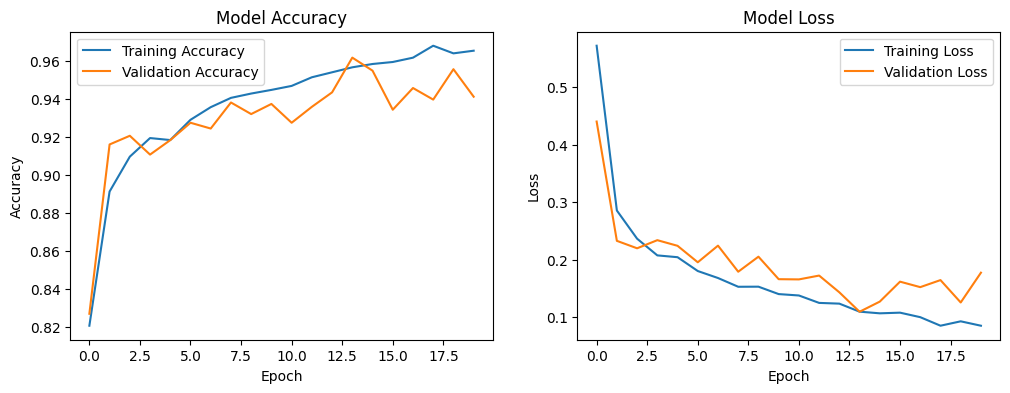

In [7]:
# Evaluating the Model / Plot training history:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [9]:
# Evaluate on the validation set:
val_loss, val_accuracy = model.evaluate(test_generator)
print(f"Validation accuracy: {val_accuracy:.2f}")

41/41 [==============================] - 24s 579ms/step - loss: 0.1776 - accuracy: 0.9413
Validation accuracy: 0.94


In [14]:
# Set the image dimensions
IMG_WIDTH = IMG_SIZE

# Load and preprocess images
def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    #img = img / 255.0  # Normalize pixel values
    return img


In [23]:
# Making Predictions
def predict_image(image_path):
    img = load_and_preprocess_image(image_path)
    img = tf.expand_dims(img, 0)  # Add batch dimension
    prediction = model.predict(img)
    class_index = tf.argmax(prediction[0]).numpy()
    class_name = class_names[class_index]
    confidence = prediction[0][class_index]
    return class_name, confidence

# Example usage
result_class, result_confidence = predict_image('/content/gdrive/MyDrive/BrainTumorsClassifier/test-glioma3.jpg')
print(f"Predicted class: {result_class}, Confidence: {result_confidence:.2f}")

1/1 [==============================] - 0s 82ms/step
Predicted class: glioma, Confidence: 1.00
